In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import photutils

from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

from photutils.detection import DAOStarFinder
from photutils.morphology import data_properties
from astropy.stats import mad_std

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Dense, Flatten, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse

from tensorflow.config import list_logical_devices, list_physical_devices, set_visible_devices
from tensorflow.config.experimental import set_memory_growth




In [2]:
#Setup notebook so Tensorflow works in a friendly way in a shared multi GPU env

def setup_tensorflow(seed=None):
    try:
        import nvsmi
        gpu_mem_free = np.array([gpu.mem_free for gpu in nvsmi.get_gpus()])
        if len(gpu_mem_free) > 0 and (gpu_mem_free > 0).any():
            idx = np.argmax(gpu_mem_free)
            gpu = list_physical_devices("GPU")[idx]
            set_memory_growth(gpu, True)
            set_visible_devices(gpu, "GPU")
            gpus = list_logical_devices("GPU")
            print(f"Using GPU: {gpus}")
        else:
            raise Exception
    except:
        print(f"Tensorflow using CPU")
    tf.random.set_seed(seed)


In [3]:
#If working in a multiply GPU setup run setup_tensorflow()

setup_tensorflow()

Using GPU: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2022-05-04 16:58:24.497251: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-04 16:58:24.959244: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9650 MB memory:  -> device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:b3:00.0, compute capability: 7.5


In [14]:
#load the image arrays, Size: (ngals, 64, 64), (2, ngals, 64, 64) respectively 

blends = np.load("central_blends.npy")
components = np.load("central_components.npy")
     

In [15]:
#Constant factor normalisation 

#Lets just divide them all by the maximum value found 

norm_max = np.max([ np.max(blends), np.max(components) ])

blends = blends / norm_max 

components = components / norm_max

In [ ]:
"""

#Min Max Norm

norm_max = np.max([ np.max(blends), np.max(components) ])
norm_min = np.min([ np.min(blends), np.min(components) ])


blends = (blends - norm_min) / (norm_max - norm_min) 

components = (components - norm_min) / (norm_max - norm_min)

"""

In [16]:
blends.shape, components.shape

((3000, 64, 64), (2, 3000, 64, 64))

In [19]:
np.mean(blends), np.mean(components)

(0.06959599890014684, 0.034797999450073384)

In [20]:
#This should be close to 0 or orders of magnitude smaller than the mean of the blends / components 
print(np.sum(blends - (components[0] + components[1])))

7.610130335670821e-14


In [7]:
#Split into training and test set 

#Going to split training and test 80% and 20% respectively 

train_ngals = int(blends.shape[0] * 0.8)
test_ngals = int(blends.shape[0] * 0.2)

train_blends = blends[:train_ngals]
test_blends = blends[train_ngals:]

blends = []

a, b, c, d, test_components = np.split(components, 5, axis = 1)

components = []

train_components = np.concatenate((a, b, c, d), axis = 1)






In [8]:
train_components.shape, test_components.shape

((2, 2400, 64, 64), (2, 600, 64, 64))

In [10]:
np.amax(train_blends), np.amin(train_blends), np.amax(test_blends), np.amin(test_blends)

(1.0, -0.050326388124580436, 0.9557487264880407, -0.05123629293813056)

In [11]:
np.amax(test_components), np.amin(test_components), np.amax(test_blends), np.amin(test_blends)

(0.9557303808405417,
 -0.05140335591825336,
 0.9557487264880407,
 -0.05123629293813056)

In [12]:
height,width=64,64

train_blends = train_blends.reshape(train_ngals, height, width, 1).astype('float32')
train_components = train_components.reshape(2, train_ngals, height, width, 1).astype('float32')

test_blends = test_blends.reshape(test_ngals, height, width, 1).astype('float32')
test_components = test_components.reshape(2, test_ngals, height, width, 1).astype('float32')


In [13]:
batch_size = 32
latent_dimensions = 32

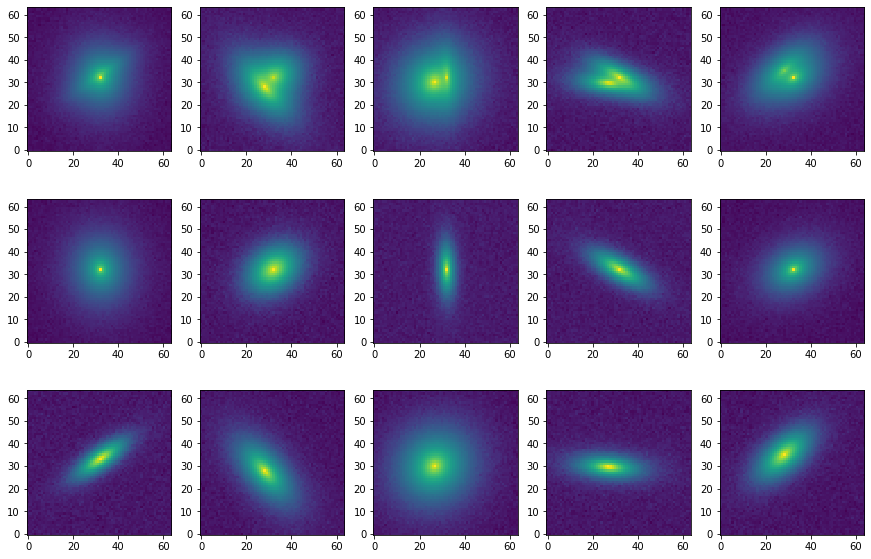

In [15]:
fig, ax = plt.subplots(train_components.shape[0] + 1, 5, figsize=(15, 10))
for i in range(5):
    ax[0, i].imshow(train_blends[i], origin='lower', interpolation='nearest')
    ax[1, i].imshow(train_components[0, i], origin='lower', interpolation='nearest')
    ax[2, i].imshow(train_components[1, i], origin='lower', interpolation='nearest')

In [16]:
#Will optimise encoder / decoder later
def encoder(x):
    x = Conv2D(32,3,activation='relu',padding='same', strides=2)(x)
    x = Conv2D(64,3,activation='relu',padding='same', strides=2)(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    return x

In [17]:
def decoder(x):
    x = UpSampling2D(size=(2,2))(x)
    x = Conv2DTranspose(64,3,activation='relu',padding='same', strides=2)(x)
    x = Conv2DTranspose(32,3,activation='relu',padding='same', strides=2)(x)
    return x

In [18]:
def sampling(args):
    z_mean,z_log_sigma=args
    epsilon=tf.random.normal(shape=tf.shape(z_mean))
    z=z_mean+tf.exp(0.5*z_log_sigma)*epsilon
    return z

In [19]:
# encoder
input_blend=Input(shape=(height, width,1))

encoded=encoder(input_blend)
shape=encoded.get_shape()[1:]
encoded=Flatten()(encoded)

z_mean=Dense(latent_dimensions)(encoded)
z_log_sigma=Dense(latent_dimensions)(encoded)
z=Lambda(sampling)([z_mean,z_log_sigma])

In [20]:
# decoder
input_embed=Input(shape=latent_dimensions)

embed1=Dense(np.prod(shape),activation='relu')(input_embed)
embed1=Reshape(shape)(embed1)
decoded1=decoder(embed1)
output1=Conv2DTranspose(1,3,padding='same')(decoded1)


In [21]:
encode=Model(input_blend,z)
encode.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 8, 8, 64)     0           ['conv2d_1[0][0]']               
                                                                                              

In [22]:
input_component1 = Input(shape=(height, width, 1))

decode=Model([input_embed, input_component1], [output1])
decode.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 4096)         135168      ['input_2[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 8, 8, 64)     0           ['dense_2[0][0]']                
                                                                                                  
 up_sampling2d (UpSampling2D)   (None, 16, 16, 64)   0           ['reshape[0][0]']                
                                                                                            

In [23]:
encoding = encode(input_blend)
re1 = decode([encoding, input_component1])

vae = Model([input_blend, input_component1], [re1])

In [24]:
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 32)           281024      ['input_1[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 model_1 (Functional)           (None, 64, 64, 1)    190849      ['model[0][0]',                  
                                                                  'input_3[0][0]']          

In [25]:
#In our loss we are only going to compare to the central image i.e component 1 

mse_loss = tf.reduce_mean(mse(input_component1,re1)) * height * width
vae.add_loss(mse_loss)
vae.add_metric(mse_loss, 'mse_loss')

beta = 0.1 
kl_loss=tf.reduce_mean(-0.5*(1+z_log_sigma-tf.square(z_mean)-tf.exp(z_log_sigma)))*beta
vae.add_loss(kl_loss)
vae.add_metric(kl_loss,'kl_loss')


train_together = [train_blends, train_components[0]]
test_together = [test_blends, test_components[0]]

#need an array which has the blends and both components for later use of calculating metrics - this will be using the test set 

metrics_together = [test_blends, test_components[0], test_components[1]]


vae.compile(optimizer=Adam())

In [26]:
val_split_ratio = 0.1
print(val_split_ratio * train_ngals)

9600.0


In [27]:
#training
history=vae.fit(train_together, verbose=1, epochs=100, batch_size=batch_size, validation_split = val_split_ratio)

Epoch 1/100


2022-04-27 17:06:31.887906: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


2700/2700 [==============================] - 34s 11ms/step - loss: 2.3647 - mse_loss: 2.1803 - kl_loss: 0.1843 - val_loss: 1.5985 - val_mse_loss: 1.4227 - val_kl_loss: 0.1758
Epoch 2/100
2700/2700 [==============================] - 28s 10ms/step - loss: 1.2945 - mse_loss: 1.1276 - kl_loss: 0.1669 - val_loss: 1.0796 - val_mse_loss: 0.9214 - val_kl_loss: 0.1582
Epoch 3/100
2700/2700 [==============================] - 28s 10ms/step - loss: 1.0294 - mse_loss: 0.8860 - kl_loss: 0.1434 - val_loss: 0.9345 - val_mse_loss: 0.7938 - val_kl_loss: 0.1406
Epoch 4/100
2700/2700 [==============================] - 29s 11ms/step - loss: 0.9211 - mse_loss: 0.7906 - kl_loss: 0.1305 - val_loss: 0.8467 - val_mse_loss: 0.7229 - val_kl_loss: 0.1238
Epoch 5/100
2700/2700 [==============================] - 27s 10ms/step - loss: 0.8527 - mse_loss: 0.7286 - kl_loss: 0.1241 - val_loss: 0.8937 - val_mse_loss: 0.7686 - val_kl_loss: 0.1251
Epoch 6/100
2700/2700 [==============================] - 28s 10ms/step - loss

In [28]:
def histplot(history):
    plt.rcParams["figure.figsize"] = (10,7)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, label = 'Training loss')
    plt.plot(epochs, val_loss, label = 'Validation loss')
    plt.axhline( y = min(val_loss), color = 'black', linestyle = 'dotted', label = f'Minimum Validation Loss: {min(val_loss):.4f}')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

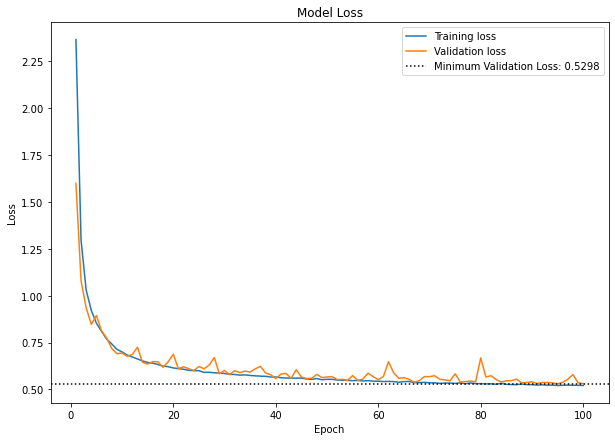

In [29]:
histplot(history)

In [30]:
def showimg(img, ax, title=None, vmin=0, vmax=1):
    ax.imshow(img.squeeze(), vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('off')



def summary_plot(n,inputs,decode,seed=1):
    np.random.seed(seed)
    #idx=np.array([0,1,2,3,4])
    idx = np.random.choice(len(inputs[0]), size=n, replace=False)
    print(idx)
    input_img = inputs[0][idx]
    #Comp 1 = Central Comp, Comp 2 = Residual
    comp1 = inputs[1][idx]
    comp2 = inputs[2][idx]
    z = encode.predict(input_img)
    output_img = decode.predict([z,comp1])
    comp1.shape, output_img.shape
    fig, ax = plt.subplots(6, n, figsize=((3)*n,15))
    for i in range(n):
        ax[0, i].imshow(input_img[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75)
        ax[0, i].set_title('Input Blend')
        ax[1, i].imshow(comp1[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75 )
        ax[1, i].set_title('Input Central Component')
        ax[2, i].imshow(comp2[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75 )
        ax[2, i].set_title('Input Component 2')
        ax[3, i].imshow(output_img[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75 )
        ax[3, i].set_title('Output Central Component')
        ax[4, i].imshow(input_img[i] - output_img[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75 )
        ax[4, i].set_title('Output Residual Component')
        ax[5, i].imshow(abs(comp1[i] - output_img[i]), origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75 )
        ax[5, i].set_title('Central Component Difference')
        plt.tight_layout()
    return idx


[ 6414 13523  8374  5256  4405]


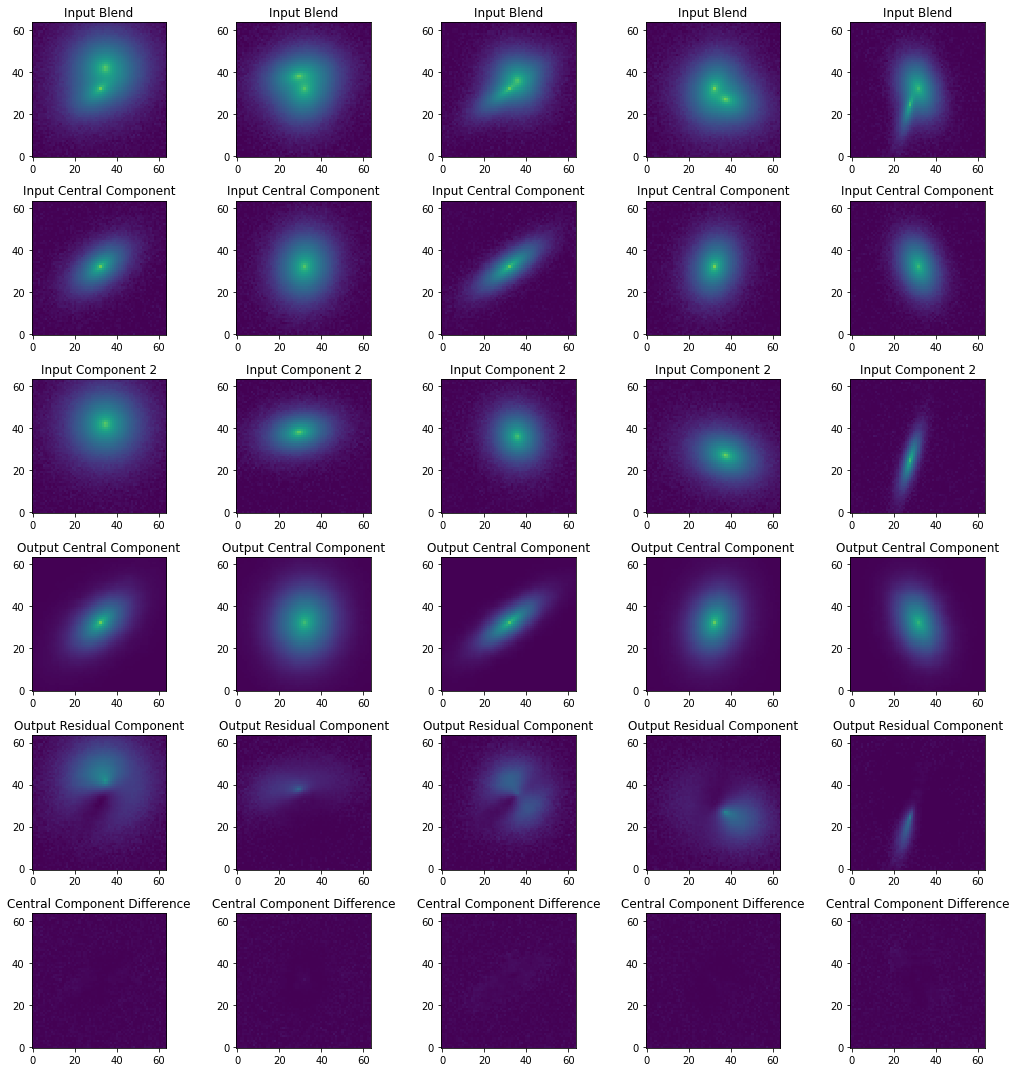

In [31]:
n=5
chosen=summary_plot(n,metrics_together,decode)

In [32]:
def calc_ssim(inputs,decode):
    ssim_comp1 = np.zeros(test_ngals)
    ssim_comp2 = np.zeros(test_ngals)
    ssim_blends = np.zeros(test_ngals)
    input_img = inputs[0]
    #Comp 1 = Central Comp, Comp 2 = Residual
    comp1 = inputs[1]
    comp2 = inputs[2]
    z = encode.predict(input_img)
    output_img1 = decode.predict([z, comp1])
    for i in range(test_ngals):
        ssim_comp1[i] = ssim(comp1[i], output_img1[i], channel_axis=2)
        ssim_comp2[i] = ssim(comp2[i], (input_img[i] - output_img1[i]), channel_axis=2)
    mean_ssim_comp1 = np.mean(ssim_comp1)
    median_ssim_comp1 = np.median(ssim_comp1)
    
    mean_ssim_comp2 = np.mean(ssim_comp2)
    median_ssim_comp2 = np.median(ssim_comp2)

    ssim_values = np.array([mean_ssim_comp1, median_ssim_comp1, mean_ssim_comp2, median_ssim_comp2 ])
    
    return ssim_values 
        
    
    

In [33]:
ssim_values = calc_ssim(metrics_together, decode)

In [34]:

mean_ssim_comp1 = ssim_values[0]
median_ssim_comp1 = ssim_values[1]
mean_ssim_comp2 = ssim_values[2]
median_ssim_comp2 = ssim_values[3]


In [35]:
print(f' Mean SSIMs: Central Component: {mean_ssim_comp1:.4f}, Residual Component: {mean_ssim_comp2:.4f}')

print(f' Median SSIMs: Central Component: {median_ssim_comp1:.4f}, Residual Component: {median_ssim_comp2:.4f} ')


 Mean SSIMs: Central Component: 0.9717, Residual Component: 0.8535
 Median SSIMs: Central Component: 0.9742, Residual Component: 0.8572 


In [36]:
#This function calculates the properties of the input and output images. The ellipticity and flux are stored in arrays 

def calc_properties(inputs,decode):
    
    empty_array = np.zeros(test_ngals)
    
    flux_in_comp1 = np.zeros(test_ngals)
    
    flux_out_comp1 = np.zeros(test_ngals)
    
    elip_in_comp1 = np.zeros(test_ngals)
    
    elip_out_comp1 = np.zeros(test_ngals)
    
    flux_in_comp2 = np.zeros(test_ngals)
    
    flux_out_comp2 = np.zeros(test_ngals)
    
    elip_in_comp2 = np.zeros(test_ngals)

    elip_out_comp2 = np.zeros(test_ngals)
    
    input_img = inputs[0]
    input_img = input_img.reshape(test_ngals, height, width)
    comp1 = inputs[1]
    comp1 = comp1.reshape(test_ngals, height, width)
    comp2 = inputs[2]
    comp2 = comp2.reshape(test_ngals, height, width)
    
    z = encode.predict(input_img)
    output_img1 = decode.predict([z, comp1])
    output_img1 = output_img1.reshape(test_ngals, height, width)
    
    for i in range(test_ngals):
        
        in_comp1_cat = photutils.morphology.data_properties(comp1[i], mask = None, background = 0)
        elip_in_comp1[i] = in_comp1_cat.ellipticity
        flux_in_comp1[i] = in_comp1_cat.segment_flux
            
        out_comp1_cat = photutils.morphology.data_properties(output_img1[i], mask = None, background = 0)
        elip_out_comp1[i] = out_comp1_cat.ellipticity
        flux_out_comp1[i] = out_comp1_cat.segment_flux
        
        in_comp2_cat = photutils.morphology.data_properties(comp2[i], mask = None, background = 0)
        elip_in_comp2[i] = in_comp2_cat.ellipticity
        flux_in_comp2[i] = in_comp2_cat.segment_flux
            
        out_comp2_cat = photutils.morphology.data_properties(input_img[i] - output_img1[i], mask = None, background = 0)
        elip_out_comp2[i] = out_comp2_cat.ellipticity
        flux_out_comp2[i] = out_comp2_cat.segment_flux
        
        parameters = [elip_in_comp1, elip_out_comp1, flux_in_comp1, flux_out_comp1, elip_in_comp2, elip_out_comp2, flux_in_comp2, flux_out_comp2]   
    return parameters


        

In [37]:
parameters = calc_properties(metrics_together, decode)

In [38]:

ellip_in_comp1 = parameters[0]
ellip_out_comp1 = parameters[1]
flux_in_comp1 = parameters[2]
flux_out_comp1 = parameters[3]
ellip_in_comp2 = parameters[4]
ellip_out_comp2 = parameters[5]
flux_in_comp2 = parameters[6]
flux_out_comp2 = parameters[7]



In [39]:
#Calculate the standard deviations 
def calc_std(parameters):
    num_of_params = len(parameters)
    standard_dev_of_params = np.zeros(num_of_params)
    for i in range(0,num_of_params):
        standard_dev_of_params[i] = np.std(parameters[i])
    return standard_dev_of_params



In [40]:
std_of_params = calc_std(parameters)

print(std_of_params)


[ 0.12503258  0.21593305 81.89318572 80.14561516  0.11980281  0.11410514
 80.29460567 63.26287086]


In [41]:
print(f'Std dev of Ellip: Central Comp [In] {std_of_params[0]:.4f}, Central Comp [Out] {std_of_params[1]:.4f}, Residual Comp [In] {std_of_params[4]:.4f}, Residual Comp [Out] {std_of_params[5]:.4f} ')
print(f'Std dev of Flux: Central Comp [In] {std_of_params[2]:.4f}, Central Comp [Out] {std_of_params[3]:.4f}, Residual Comp [In] {std_of_params[6]:.4f}, Residual Comp [Out] {std_of_params[7]:.4f} ')

Std dev of Ellip: Central Comp [In] 0.1250, Central Comp [Out] 0.2159, Residual Comp [In] 0.1198, Residual Comp [Out] 0.1141 
Std dev of Flux: Central Comp [In] 81.8932, Central Comp [Out] 80.1456, Residual Comp [In] 80.2946, Residual Comp [Out] 63.2629 


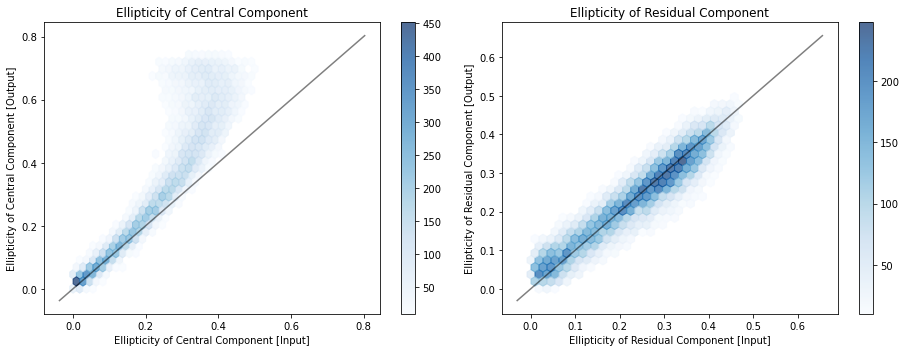

In [42]:

fig, axes = plt.subplots(1, 2, figsize = (13,5))

#Lets make minimum amount of number of points in a cell to display scale with number of test samples

n_mincnt = np.floor(test_blends.shape[0] / 10000) + 1


axes[0].set_title("Ellipticity of Central Component")
hex1 = axes[0].hexbin(ellip_in_comp1, ellip_out_comp1, gridsize=30, cmap='Blues', mincnt= n_mincnt, alpha=0.7)
axes[0].set_xlabel("Ellipticity of Central Component [Input]")
axes[0].set_ylabel("Ellipticity of Central Component [Output]")
fig.colorbar(hex1, ax=axes[0])

lims = [
    np.min([axes[0].get_xlim(), axes[0].get_ylim()]),  # min of both axes
    np.max([axes[0].get_xlim(), axes[0].get_ylim()]),  # max of both axes
]


# now plot both limits against eachother
axes[0].plot(lims, lims, 'k-', alpha=0.5, zorder=1)

axes[1].set_title("Ellipticity of Residual Component")
hex2 = axes[1].hexbin(ellip_in_comp2, ellip_out_comp2, gridsize=30, cmap='Blues', mincnt= n_mincnt, alpha=0.7)
axes[1].set_xlabel("Ellipticity of Residual Component [Input]")
axes[1].set_ylabel("Ellipticity of Residual Component [Output]")
fig.colorbar(hex2, ax=axes[1])

lims = [
    np.min([axes[1].get_xlim(), axes[1].get_ylim()]),  # min of both axes
    np.max([axes[1].get_xlim(), axes[1].get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
axes[1].plot(lims, lims, 'k-', alpha=0.5, zorder=1)


fig.tight_layout()

plt.show()


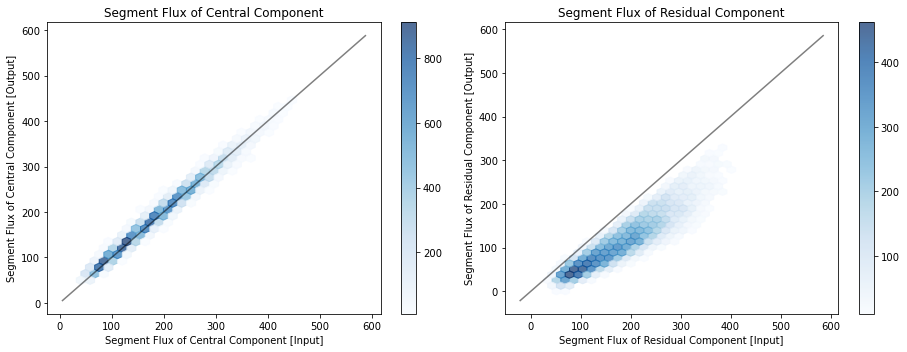

In [43]:
fig, axes = plt.subplots(1, 2, figsize = (13,5))

axes[0].set_title("Segment Flux of Central Component")
hex1 = axes[0].hexbin(flux_in_comp1, flux_out_comp1, gridsize=30, cmap='Blues', mincnt= n_mincnt, alpha=0.7)
axes[0].set_xlabel("Segment Flux of Central Component [Input]")
axes[0].set_ylabel("Segment Flux of Central Component [Output]")
fig.colorbar(hex1, ax=axes[0])

lims = [
    np.min([axes[0].get_xlim(), axes[0].get_ylim()]),  # min of both axes
    np.max([axes[0].get_xlim(), axes[0].get_ylim()]),  # max of both axes
]


# now plot both limits against eachother
axes[0].plot(lims, lims, 'k-', alpha=0.5, zorder=1)

axes[1].set_title("Segment Flux of Residual Component")
hex2 = axes[1].hexbin(flux_in_comp2, flux_out_comp2, gridsize=30, cmap='Blues', mincnt= n_mincnt, alpha=0.7)
axes[1].set_xlabel("Segment Flux of Residual Component [Input]")
axes[1].set_ylabel("Segment Flux of Residual Component [Output]")
fig.colorbar(hex2, ax=axes[1])

lims = [
    np.min([axes[1].get_xlim(), axes[1].get_ylim()]),  # min of both axes
    np.max([axes[1].get_xlim(), axes[1].get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
axes[1].plot(lims, lims, 'k-', alpha=0.5, zorder=1)


fig.tight_layout()

plt.show()

In [44]:


# abs(Output / Input) * 100

ellip_comp1_accuracy = abs(ellip_out_comp1 / ellip_in_comp1) * 100
mean_ellip_comp1_accuracy = np.mean(ellip_comp1_accuracy)
median_ellip_comp1_accuracy = np.median(ellip_comp1_accuracy)


flux_comp1_accuracy = abs(flux_out_comp1 / flux_in_comp1) * 100
mean_flux_comp1_accuracy = np.mean(flux_comp1_accuracy)
median_flux_comp1_accuracy = np.median(flux_comp1_accuracy)


ellip_comp2_accuracy = abs(ellip_out_comp2 / ellip_in_comp2) * 100
mean_ellip_comp2_accuracy = np.mean(ellip_comp2_accuracy)
median_ellip_comp2_accuracy = np.median(ellip_comp2_accuracy)


flux_comp2_accuracy = abs(flux_out_comp2 / flux_in_comp2) * 100
mean_flux_comp2_accuracy = np.mean(flux_comp2_accuracy)
median_flux_comp2_accuracy = np.median(flux_comp2_accuracy)





In [45]:
print(f' Mean ellipticity accuracys: Central Component: {mean_ellip_comp1_accuracy :.4f}, Residual Component: {mean_ellip_comp2_accuracy:.4f}')
print(f' Median ellipticity accuracys: Central Component: {median_ellip_comp1_accuracy:.4f}, Residual Component: {median_ellip_comp2_accuracy:.4f} \n')
print(f' Mean flux accuracys: Central Component: {mean_flux_comp1_accuracy:.4f}, Residual Component: {mean_flux_comp2_accuracy}')
print(f' Median flux accuracys: Central Component: {median_flux_comp1_accuracy:.4f}, Residual Component: {median_flux_comp2_accuracy:.4f}')

 Mean ellipticity accuracys: Central Component: 146.9117, Residual Component: 120.3159
 Median ellipticity accuracys: Central Component: 130.1947, Residual Component: 100.4277 

 Mean flux accuracys: Central Component: 102.9022, Residual Component: 61.1247004809982
 Median flux accuracys: Central Component: 101.8630, Residual Component: 61.1069
